In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats

# import pystan
import pymc3 as pm
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

file = 'data/c10/d.csv'
df = pd.read_csv(file)
print(df.head(10))

   plant.ID  y     alpha
0         1  0 -4.159582
1         2  0 -3.718362
2         3  0 -3.069020
3         4  0 -3.054211
4         5  0 -2.880656
5         6  2 -2.705595
6         7  1 -2.441703
7         8  1 -2.221327
8         9  0 -2.209120
9        10  1 -2.111941


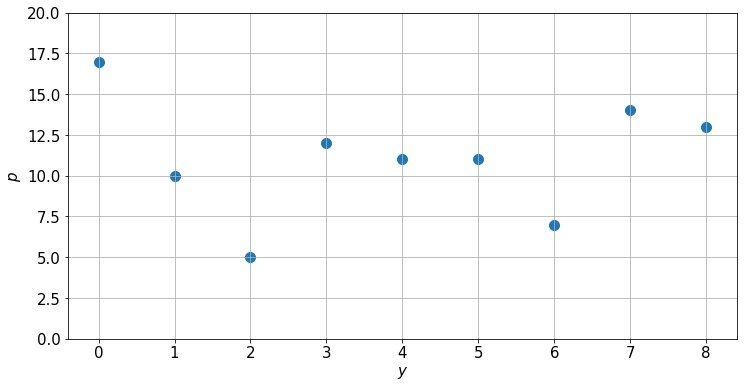

In [3]:
y_list = df['y'].values

bins = 9
hist_y = np.histogram(y_list, bins=bins)[0]

xx = np.arange(9)
plt.figure(figsize=(12,6))
plt.rcParams["font.size"] = 15
plt.scatter(xx, hist_y, s=100)

plt.xlabel('$y$')
plt.ylabel('$p$')
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid()
plt.ylim(0, 20)
plt.show()


G:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -316.78, ||grad|| = 4: 100%|██████████████████████| 5/5 [00:00<?, ?it/s]


0.4960000053023121


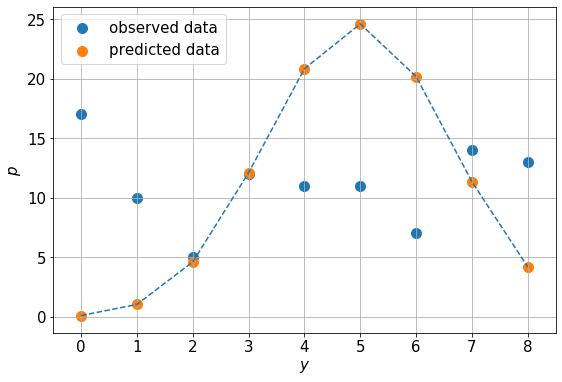

In [14]:
# MAP推定を行う。
model = pm.Model()
with model:
    q = pm.Uniform('q', lower=0, upper=1)
    y = pm.Binomial('y', n=10, p=q, observed=y_list)
    map_estimate = pm.find_MAP(model=model)
print(map_estimate['q'])


# 推定したqを用いて二項分布を作る。
rv = scipy.stats.binom(10, map_estimate['q'])
bino_ys = [100 * rv.pmf(k) for k in range(9)]

# %%
# この二項分布を描画する。
plt.figure(figsize=(9,6))
plt.rcParams["font.size"] = 15
plt.scatter(xx, hist_y, s=100, label='observed data')
plt.scatter(xx, bino_ys, s=100, label='predicted data')
plt.plot(xx, bino_ys, ls='--')
plt.xlabel('$y$')
plt.ylabel('$p$')
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid()
plt.legend(loc='best')
plt.show()

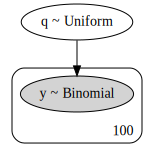

In [5]:
pm.model_to_graphviz(model)

In [6]:
# 階層ベイス推定をMCMCで解く。
with pm.Model() as model_hi:
    beta  = pm.Normal('beta', mu=0, tau=1.0e-2)
    tau   = pm.Gamma('tau', alpha=1.0e-02, beta=1.0e-02)
    alpha = pm.Normal('alpha', mu=0, tau=tau , shape=len(y_list))
    ymu   = pm.math.sigmoid(beta + alpha)
    y     = pm.Binomial('y', n=10, p=ymu, observed=y_list)
    start = pm.find_MAP()
    step  = pm.NUTS()
    trace = pm.sample(5000, start=start, step=step)
alpha.shape

G:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -48.984, ||grad|| = 0.031497: 100%|███| 33/33 [00:00<00:00, 2358.88it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, beta]
Sampling 4 chains: 100%|█████████████| 22000/22000 [00:37<00:00, 590.35draws/s]


Shape.0

<MultiTrace: 4 chains, 5000 iterations, 4 variables>


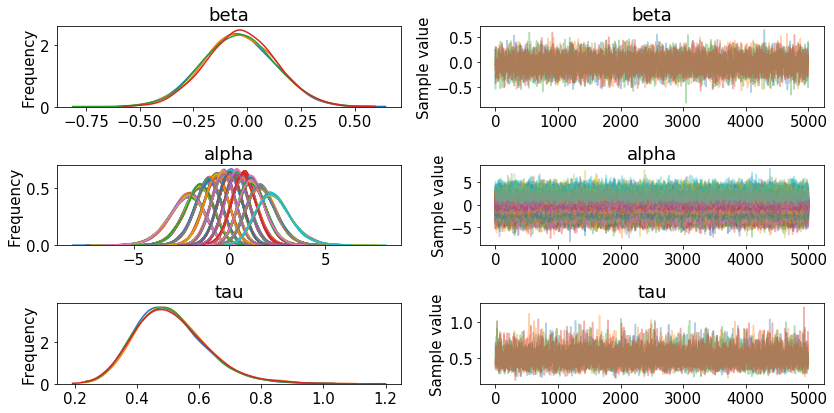

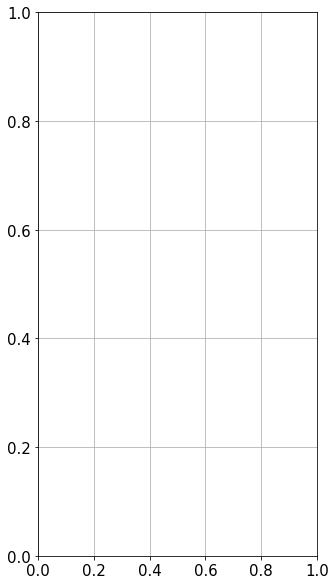

In [7]:
# 結果の確認
print(trace)
pm.traceplot(trace)
plt.figure(figsize=(5, 10))
plt.grid()
plt.show()

In [8]:
# 収束をチェックする。
pm.gelman_rubin(trace)

{'beta': 1.0006092389159937,
 'alpha': array([0.99994702, 0.99991663, 1.00023325, 0.99990308, 0.99995654,
        0.99992602, 0.99993375, 0.99993469, 0.99997401, 0.99994383,
        0.99999236, 0.99993968, 1.00011565, 1.00002778, 0.99992333,
        0.99996874, 1.00007717, 1.00001647, 0.99994755, 0.9999143 ,
        1.00004461, 0.9999678 , 0.99993946, 1.00010866, 1.00002776,
        0.99995009, 0.999967  , 1.00021155, 1.00008924, 1.00007646,
        0.99998846, 0.99998862, 0.99993928, 0.99994573, 1.00003694,
        0.99996556, 1.00017433, 0.99998506, 0.99993049, 0.99995774,
        0.99997106, 1.00000418, 1.00016273, 0.99992461, 1.00002023,
        1.0000573 , 1.00014666, 1.0000514 , 1.0000231 , 0.99998076,
        1.00002464, 1.00000035, 1.00017698, 1.00002861, 0.99997897,
        0.99995372, 0.99998016, 1.0002426 , 1.00015552, 1.00006002,
        0.99999807, 1.00003737, 1.00009032, 1.00017948, 1.00000168,
        0.99996569, 0.99996256, 0.99997586, 1.00036496, 1.00006738,
        0.

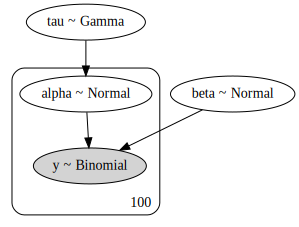

In [9]:
pm.model_to_graphviz(model_hi)

In [10]:
# 事後分布を求める。
sample_size, _ = trace['alpha'].shape
posterior = pm.sample_ppc(trace, sample_size, model=model_hi)

# yの事後分布
y_posterior = posterior['y']
print(y_posterior.shape)

# sample_sizeの数だけヒストグラムを作る。
pred_ys = np.empty((sample_size, bins))
for i, k in enumerate(y_posterior):
    pred_ys[i] = np.histogram(k, bins)[0]

# 平均をとる。
pred_mean = pred_ys.mean(axis=0)

# 標準偏差を計算する。
pred_std = pred_ys.std(axis=0)

G:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████████████████████████████| 20000/20000 [00:12<00:00, 1553.63it/s]


(20000, 100)


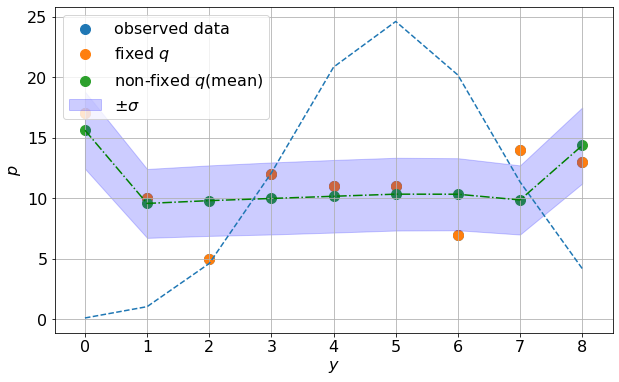

In [18]:
#  描画する。
plt.figure(figsize=(10,6))
plt.rcParams['font.size'] = 16
plt.scatter(xx, hist_y, s=100, label='observed data')

plt.plot(xx, bino_ys, ls='--')
plt.scatter(xx, hist_y, s=100, label='fixed $q$')

plt.xlabel('$y$')
plt.ylabel('$p$')

plt.plot(xx, pred_mean, ls='-.', c='g')
plt.scatter(xx, pred_mean, s=100, label='non-fixed $q$(mean)')

#plt.fill_between(xx, pred_mean - 2*pred_std, pred_mean + 2*pred_std, color='blue', alpha=0.2, label='$\pm2\sigma$')
plt.fill_between(xx, pred_mean - pred_std, pred_mean + pred_std, color='blue', alpha=0.2, label='$\pm\sigma$')

plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid()
plt.legend(loc='upper left')
plt.show()

In [ ]:
sig = pm.hpd(y_posterior, alpha=0.05)
print(sig.shape)

lower = np.histogram(sig[:, 0], bins)[0]
upper = np.histogram(sig[:, 1], bins)[0]

In [ ]:
#  描画する。
plt.figure(figsize=(9,6))
plt.rcParams['font.size'] = 16
plt.scatter(xs, hist_y, s=100, label='observed data')

# plt.plot(xs, binom_ys, ls='--')
# plt.scatter(xs, binom_ys, s=100, label='fixed $q$')

plt.xlabel('$y$')
plt.ylabel('$p$')

plt.plot(xs, pred_mean, ls='-.', c='g')
plt.scatter(xs, pred_mean, s=100, label='non-fixed $q$(mean)')

plt.fill_between(xs, lower, upper, color='gray', alpha=0.5)

plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
plt.legend(loc='best')
plt.show()